# Shap Exploration

# Imports

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap
import numpy as np
# load JS visualization code to notebook
shap.initjs()

# Data & Classification model

In [2]:
N = 100
N_BG = 100
NOISE = 0.1

In [3]:
from sklearn import datasets

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
# Load data
X,y = datasets.make_moons(N,noise=NOISE)

# split
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.9, test_size=0.1)

# fit the model
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [6]:
# Predict over the entire plane
x1, x2 = np.meshgrid(np.linspace(-1.5, 2.5, N_BG), np.linspace(-0.75, 1.25, N_BG))
X_bg = np.c_[x1.ravel(), x2.ravel()]
y_pred_bg = clf.predict_proba(X_bg)[:,1]
y_pred_bg = y_pred_bg.reshape(x1.shape)

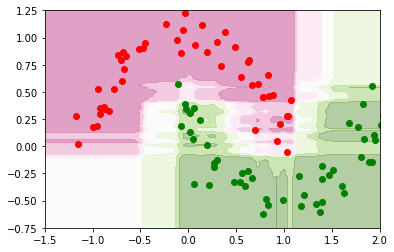

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(x1, x2, y_pred_bg, cmap='PiYG',alpha=0.4)
ax.scatter(X[y==1,0],X[y==1,1],color='green')
ax.scatter(X[y==0,0],X[y==0,1],color='red')
ax.set_xlim(-1.5,2,5);
ax.set_ylim(-0.75,1.25);

# Fit Shap

In [8]:
# Fit explainer model
explainer = shap.TreeExplainer(clf)
# Calculate shap values
shap_values = explainer.shap_values(X_bg)[1]

# Plot

In [9]:
# plot shap values
def plot_shap_dim(dim):
    if dim == 'sum':
        vals = shap_values.sum(1)
    else:
        vals = shap_values[:,dim]
        
    vals = vals.reshape(x1.shape)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.contourf(x1, x2, vals, cmap='PiYG',alpha=0.4)
    ax.scatter(X[y==1,0],X[y==1,1],color='green')
    ax.scatter(X[y==0,0],X[y==0,1],color='red')
    ax.set_xlim(-1.5,2,5);
    ax.set_ylim(-0.75,1.25);

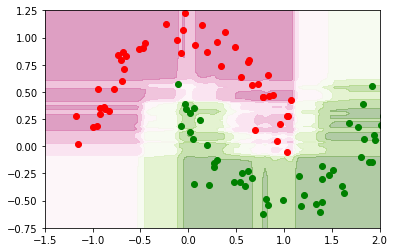

In [10]:
plot_shap_dim('sum')

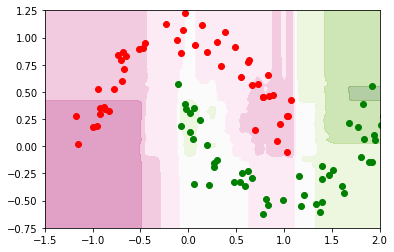

In [11]:
plot_shap_dim(0)

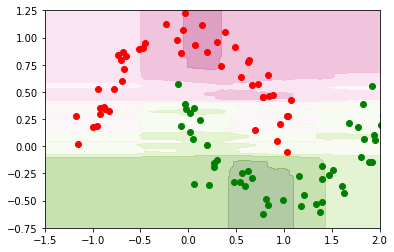

In [12]:
plot_shap_dim(1)

# Get shap for specific inputs:

In [13]:
def get_shap(explainer,X_in):
    X_in = np.array(X_in).reshape((-1,2))
    shap_vals = explainer.shap_values(X_in)[1][0]
    ev = explainer.expected_value[1]
    prob = clf.predict_proba(X_in)[0,1]
    print(f'For input: {X_in}')
    print(f'Prob({prob:.2f}) = EV ({ev:.2f}) + SH0({shap_vals[0]:.2f}) + SH1({shap_vals[1]:.2f})')

# DIY w simulation

In [14]:
# train two models with fewer features
sub_clf = {i:RandomForestClassifier(n_estimators=100,random_state=42).fit(X_train[:,i].reshape(-1,1),y_train) for i in range(2)}
clf = RandomForestClassifier(n_estimators=100,random_state=42).fit(X_train,y_train)

In [15]:
Xe = np.array([[-1,0]])

get_shap(explainer,Xe)
sub_prob = {i:sub_clf[i].predict_proba(Xe[:,i].reshape(-1,1))[0,1] for i in range(2)}
print(f'Subprobs: x0:{sub_prob[0]:.2f} and x2:{sub_prob[1]:.2f}')


For input: [[-1  0]]
Prob(0.22) = EV (0.51) + SH0(-0.37) + SH1(0.12)
Subprobs: x0:0.00 and x2:0.72


In [16]:
sub_prob

{0: 0.0, 1: 0.72}

In [17]:
clf.predict_proba(Xe)[0,1]

0.22

# Other viz


In [18]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
idx = 0
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_bg[idx,:])

Exception: In v0.20 force_plot now requires the base value as the first parameter! Try shap.force_plot(explainer.expected_value, shap_values) or for multi-output models try shap.force_plot(explainer.expected_value[0], shap_values[0]).

In [ ]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_bg)

In [ ]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("Feature 0", shap_values, X_bg)

In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_bg)

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

# Interactions

In [ ]:
interact = explainer.shap_interaction_values(X_test[0:100])

In [ ]:
shap.dependence_plot(('AGE','SEX'), interact, X_test[0:100])

In [ ]:
shap.summary_plot(shap_interaction_values, X_test[0:100])